In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
plt.style.use('classic')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv("T.csv")

In [3]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 28800

In [6]:
tf.random.set_seed(12)

In [7]:
uni_data = df['Wind Speed (m/s)']
uni_data.index = df['Date/Time']
uni_data.head()

Date/Time
01 01 2018 00:00    5.311336
01 01 2018 00:10    5.672167
01 01 2018 00:20    5.216037
01 01 2018 00:30    5.659674
01 01 2018 00:40    5.577941
Name: Wind Speed (m/s), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7a9e6c9d0>],
      dtype=object)

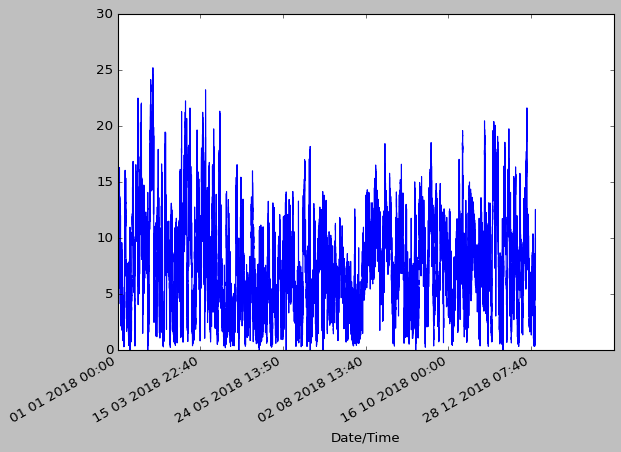

In [8]:
uni_data.plot(subplots=True)

In [9]:
uni_data = uni_data.values

In [10]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [11]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [12]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target windspeed to predict')
print (y_train_uni[0])

Single window of past history
[[-0.42943873]
 [-0.34745905]
 [-0.45109044]
 [-0.35029735]
 [-0.36886689]
 [-0.36293452]
 [-0.32000433]
 [-0.43063975]
 [-0.36734737]
 [-0.38129747]
 [-0.33565639]
 [-0.28792615]
 [-0.14860553]
 [-0.2275946 ]
 [-0.1581548 ]
 [-0.12890701]
 [-0.18688843]
 [-0.17149811]
 [-0.17867072]
 [-0.17357058]]

 Target windspeed to predict
-0.22298750096413522


In [13]:
def create_time_steps(length):
  return list(range(-length, 0))

In [14]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/sv/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

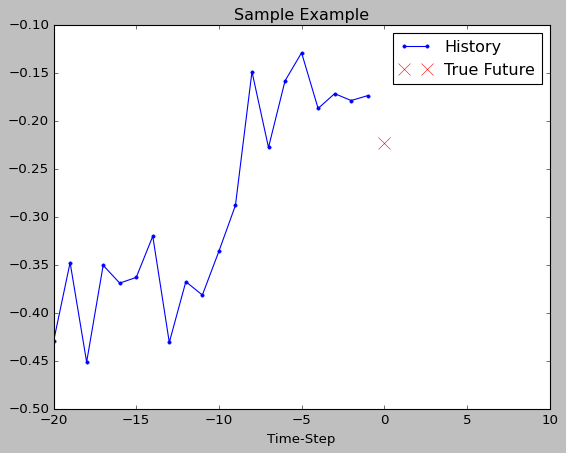

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [16]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [17]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [18]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [19]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 0.4088 - val_loss: 0.1610
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1790 - val_loss: 0.1340
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1494 - val_loss: 0.1242
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1368 - val_loss: 0.1186
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1305 - val_loss: 0.1149
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1275 - val_loss: 0.1146
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1238 - val_loss: 0.1120
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1215 - val_loss: 0.1117
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1203 - val_loss: 0.1125
Epoch 10/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1218 - val_lo

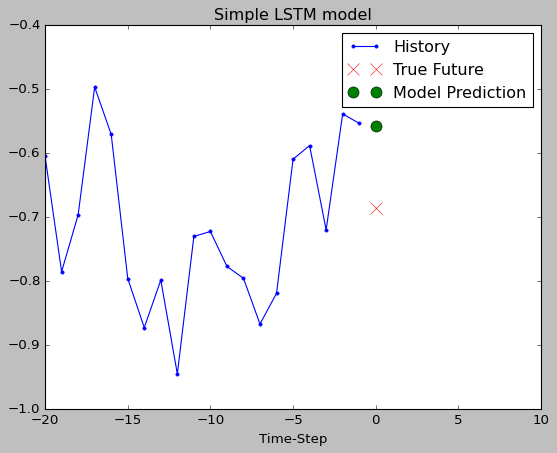

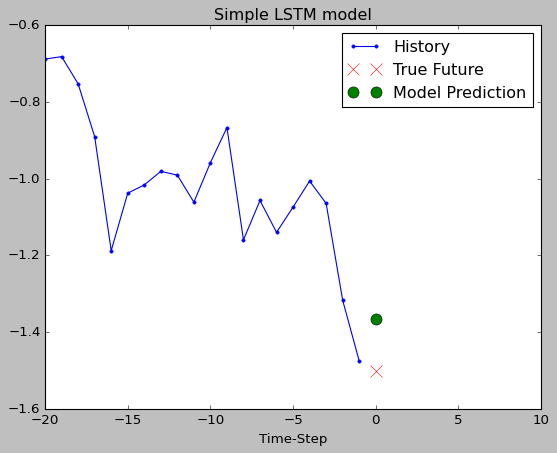

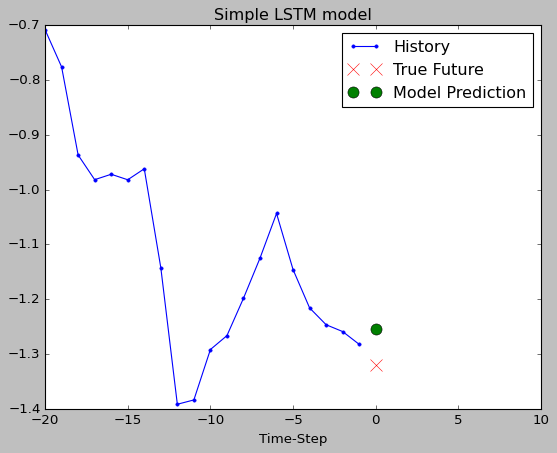

In [20]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

# Multivariate

In [21]:
features_considered = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Wind Direction (°)']

In [22]:
features = df[features_considered]
features.index = df['Date/Time']
features.head()

,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
Date/Time,,,
01 01 2018 00:00,380.047791,5.311336,259.994904
01 01 2018 00:10,453.769196,5.672167,268.641113
01 01 2018 00:20,306.376587,5.216037,272.564789
01 01 2018 00:30,419.645905,5.659674,271.258087
01 01 2018 00:40,380.650696,5.577941,265.674286


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7a9235850>,
      dtype=object)

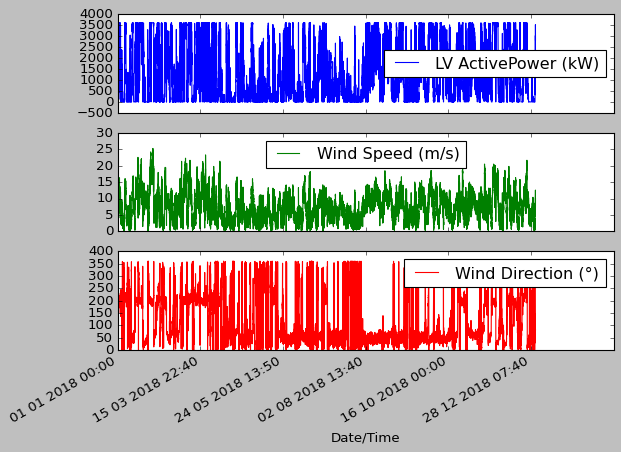

In [23]:
features.plot(subplots=True)

In [24]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [25]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [26]:
past_history = 720
future_target = 72
STEP = 6
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [27]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [28]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [29]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

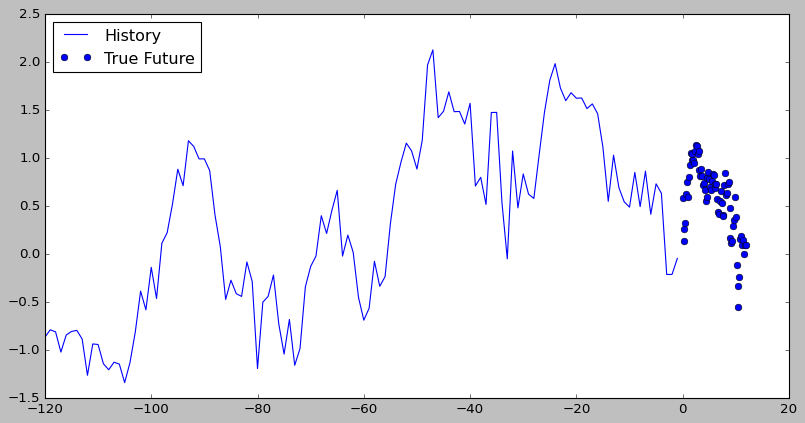

In [30]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [34]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [35]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [36]:

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 32s 161ms/step - loss: 112.2237 - val_loss: 0.5413
Epoch 2/10
200/200 [==============================] - 32s 160ms/step - loss: 347.0288 - val_loss: 0.5322
Epoch 3/10
200/200 [==============================] - 32s 162ms/step - loss: 0.5359 - val_loss: 0.5057
Epoch 4/10
200/200 [==============================] - 32s 161ms/step - loss: 0.5038 - val_loss: 0.5297
Epoch 5/10
200/200 [==============================] - 33s 164ms/step - loss: 0.4682 - val_loss: 0.6148
Epoch 6/10
200/200 [==============================] - 33s 164ms/step - loss: 0.4396 - val_loss: 0.5469
Epoch 7/10
200/200 [==============================] - 33s 164ms/step - loss: 0.4163 - val_loss: 0.5601
Epoch 8/10
200/200 [==============================] - 33s 167ms/step - loss: 14785602.0000 - val_loss: 0.5823
Epoch 9/10
200/200 [==============================] - 28s 140ms/step - loss: 0.3749 - val_loss: 0.6364
Epoch 10/10
200/200 [==============================] - 29s 147

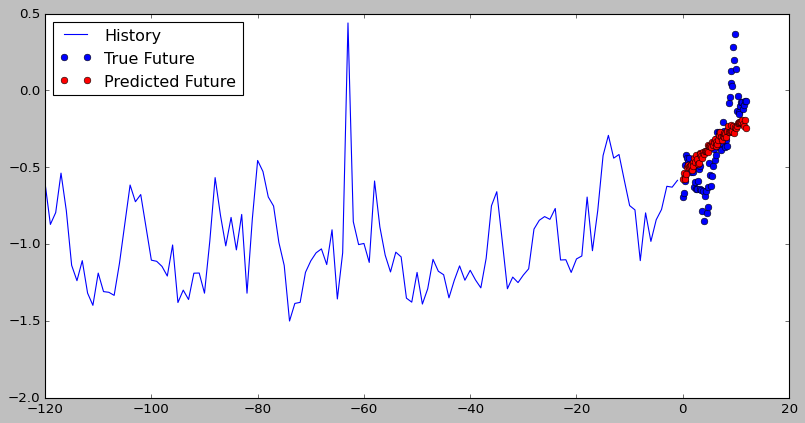

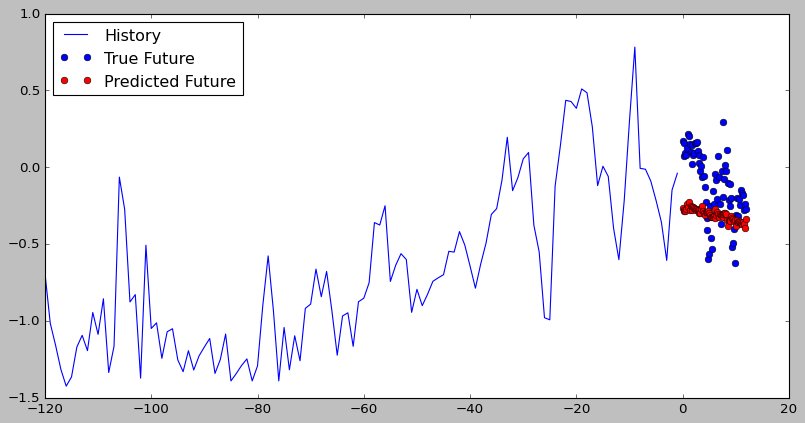

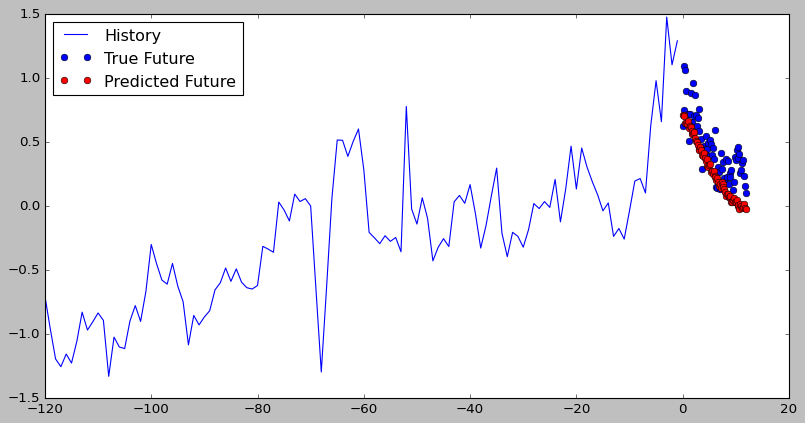

In [38]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])